In [36]:
import pandas as pd
from mplsoccer.pitch import Pitch
import numpy as np
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
from mplsoccer import Pitch, FontManager, Sbopen
import seaborn as sns
from statsbombpy import sb
import matplotlib.gridspec as gridspec

from mplsoccer import VerticalPitch, FontManager, Sbopen
from highlight_text import fig_text


In [37]:
# read csv and prepare our data
df=pd.read_csv("valladolidA.csv")

df["passer"] = df["playerId"]
df["recipient"]= df["playerId"].shift(-1)




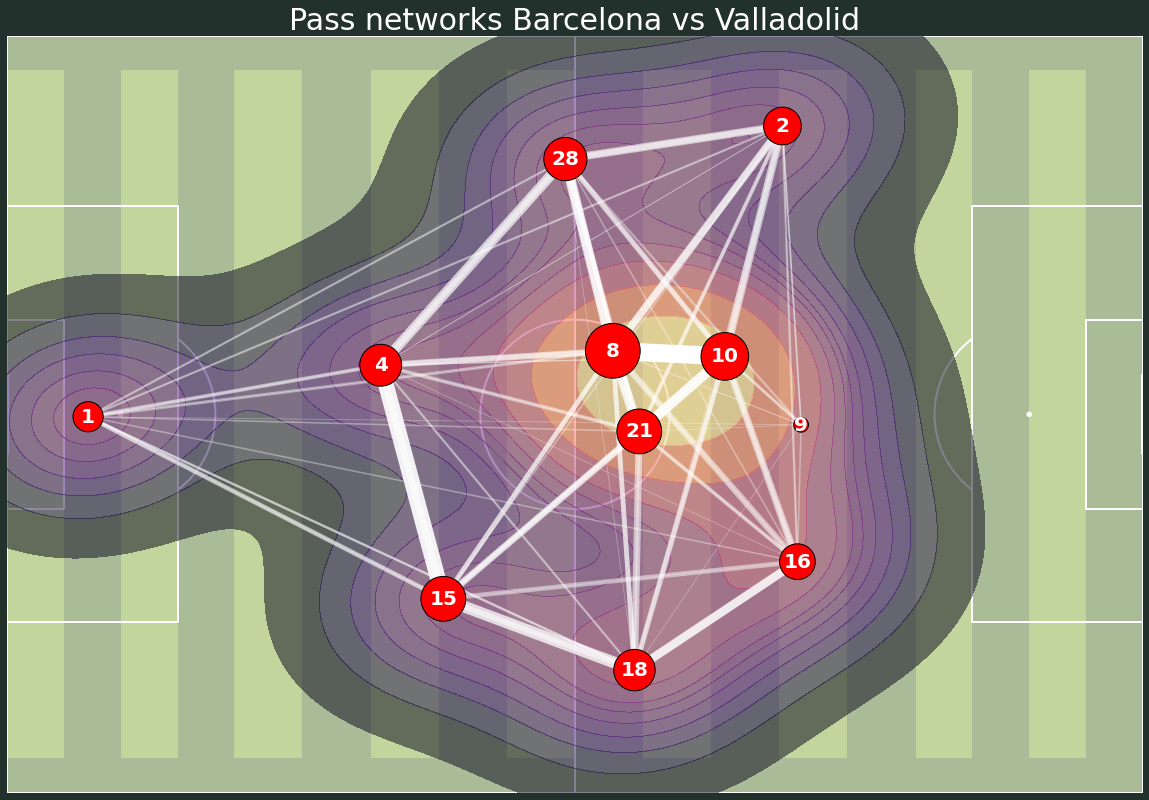

In [38]:
# lets create a function that preprocesses the data and plots the pass networks

def passnet(df, teamId):
    
    # split valladolid and barcelona data and select only successful passes
    data = df[(df["teamId"]==teamId) & (df["type"]=="Pass") &
                  (df["outcome"]=="Successful")]
    
    # find minute of first subs of each team
    sub=df[(df["type"]=="SubstitutionOff")&(df["teamId"]==teamId)]
    sub=sub["minute"]
    firstsub=sub.min()
    
    
    # select only the passes before firs subs, so we just have 11 players
    data=data[data["minute"]<firstsub]
    
    #get rid of the float value for the passer and recipient variables
    pas= pd.to_numeric(data["passer"], downcast="integer")
    rec= pd.to_numeric(data["recipient"], downcast="integer")
    data["passer"]=pas
    data["recipient"]= rec
    
    
    
    #average location of each player 
    average_location= data.groupby("passer").agg({"x":["mean"], "y":["mean","count"]})
    average_location.columns=["x","y","count"]
    
    #number of passes made between each player 
    pass_between = data.groupby(["passer","recipient"]).id.count().reset_index()
    pass_between.rename({"id":"pass_count"}, axis="columns",inplace=True)
    
    # merge average location with passes between players 
    
    pass_between = pass_between.merge(average_location, left_on='passer',right_index=True)
    pass_between = pass_between.merge(average_location, left_on='recipient',right_index=True,suffixes=['', '_end'])
    
    #lets plot 
    #we will determine the width of the passing connections using the pass_count
    MAX_LINE_WIDTH = 18
    MAX_MARKER_SIZE = 3000
    pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           MAX_LINE_WIDTH)

    average_location['marker_size'] = (average_location['count']
                                         / average_location['count'].max() * MAX_MARKER_SIZE)
    
    # Set color to make the lines more transparent when fewer passes are made
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(pass_between), 1))
    c_transparency = pass_between.pass_count / pass_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    # statsbomb data y is inverted: 
    pass_between.y=100-pass_between.y
    pass_between.y_end=100-pass_between.y_end

    average_location.y=100-average_location.y

    #plot the pitch
    pitch = Pitch(pitch_type="statsbomb", pitch_color='#aabb97', line_color='white',
                  stripe_color='#c2d59d', stripe=True )  # optional stripes
    
    fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
    fig.set_facecolor("#22312b")
    
    
    #number of each player
    indexNamesArr = average_location.index.values
    listrownames = list(indexNamesArr)
    
    average_location["numbers"]= listrownames
    
    
    # create the heatmap
    kde = sns.kdeplot(
            x=1.2*pass_between.x, y=0.8*pass_between.y, shade=True,
            cmap="magma", shade_lowest=False, threshold=0.05, ax= ax, 
            alpha=.5, n_levels=12
    )
    
    
    
    # we plot passing lines and nodes
    pass_lines = pitch.lines(1.2*pass_between.x, 0.8*pass_between.y,
                             1.2*pass_between.x_end, 0.8*pass_between.y_end, lw=pass_between.width,
                             color=color, zorder=1, ax=ax)
    
    pass_nodes = pitch.scatter(1.2*average_location.x, 0.8*average_location.y,
                               s=average_location.marker_size,
                               color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)
    
    
    for index, row in average_location.iterrows():
        pitch.annotate(row.name, xy=(1.2*row.x, 0.8*row.y), c='white', va='center',
                       ha='center', size=20, weight='bold', ax=ax)
    plt.xlim(0,120)
    plt.ylim(0,80)
    plt.title("Pass networks Barcelona vs Valladolid",color='white',size=30)
    plt.savefig("passnet.jpg")
passnet(df=df, teamId="Barcelona")

In [41]:
# lets create another function to plot the shot map 
df=pd.read_csv("valladolidA.csv")

def shot_map(df, teamId, title="Shot Map" ):
    data=df[(df["teamId"]==teamId)]
    data=data[(data["type"]=="MissedShots") | 
           (data["type"]=="SavedShot") | (data["type"]=="Goal")]
    
    shooter= pd.to_numeric(data["playerId"], downcast="integer")
    data["shooter"]=shooter
    
    # invert y axis 
    data.y=100-data.y
    
    #plot the pitch
    pitch = VerticalPitch(half=True,pitch_type="statsbomb", pitch_color='#aabb97', line_color='white',
                      stripe_color='#c2d59d', stripe=True )  # optional stripes
        
    fig, ax = pitch.draw(figsize=(8, 8), constrained_layout=True, tight_layout=False)
    fig.set_facecolor("#22312b")
    
    i=0
    for i in range(len(data["x"])): 
        if data.type.tolist()[i]=="Goal":
            plt.scatter(0.8*data.y.tolist()[i], 1.2*data.x.tolist()[i], c="green", s=120)
        elif data.type.tolist()[i]=="SavedShot":
            plt.scatter(0.8*data.y.tolist()[i], 1.2*data.x.tolist()[i], c="red", s=120)
        else: 
            plt.scatter(0.8*data.y.tolist()[i], 1.2*data.x.tolist()[i], c="red", s=120)
        
        i=i+1
    text_color = 'w'

    total_shots = len(data)
    
    fig_text(s=f'Total Shots: {total_shots}',
            x=.32, y =.30, fontsize=20,fontfamily='Andale Mono',color=text_color)
    
    fig_text(s=f'Goals: 3',
            x=.60, y =.30, fontsize=20,fontfamily='Andale Mono',color=text_color)

    plt.title(title,color='white',size=20)

    plt.savefig("shotmap.jpg")

findfont: Font family ['Andale Mono'] not found. Falling back to DejaVu Sans.


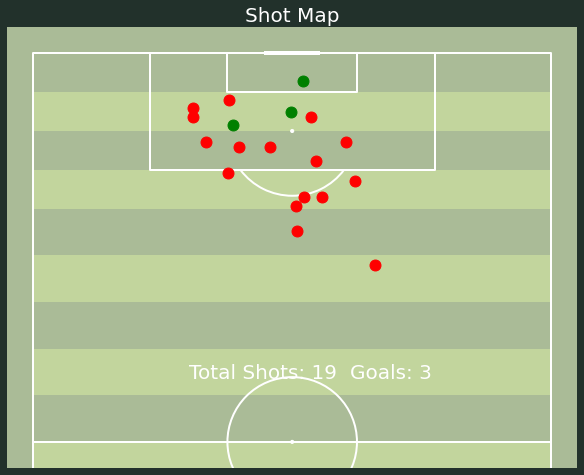

In [42]:
shot_map(df=df, teamId="Barcelona")